In [1]:
from transformers import AutoModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Positional Encoding Matrix visualization
In GPT-2 is not sinusoidal positional encoding to be used, but rather a learned-position embedding. Let's see what the NxD $\textbf{P}$ matrix looks like in this case. 

### Load GPT-2 base model (no LM head)
**Automodel** returns the base model without the language modeling head(no final prediction layer). 

**REMEMBER:**
**LM head = Language Modeling head** is a final layer (usually a linear layer + softmax) on top of the GPT-2 base model that converts the transformer's hidden states into predicted probabilities for language modeling. 
In GPT-2's case, the LM head maps from the hidden representation at each position (size 768) to a probability distribution over the vocabulary (about 50,000 tokens). To get the full GPT-2 with the LM head included, you'd have to load **AutoModelForCausalLM.from_pretrained("gpt2")**. This would allow you to tun the model end-to-end to generate text or compute likelihoods. 

Since however **here we just want to extract internal embeddings or hidden representations (like positional encoding matrix)**, there's no need to generate score or text. It is a bit simpler and uses less memory. 

**NOTICE:** However also Automodel **produced hidden states for each input token**, meaning that at each layer in the transformer, the model produces a vector representation for every token in the input sequence. These vectors are called "hidden states" or "hidden representations" (it's the NxD $X_{seq}$ evolution). They can be thought of as contextualizeed embeddings: they represent each token _in context_, considering the other tokens around it.  

In [2]:
# Load GPT-2 base model (no LM head)
model_name = "gpt2"
model = AutoModel.from_pretrained(model_name)


### Extract the learned positional embeddings

- model.wpe --> **word position embedding** layer inside GPT-2 (DIFFERENT FROM token embedding which instead is the TxE matrix)

- .weight --> accesses the embedding matrix (NxD)

- .detach() --> removes the tensor from the Pytorch computational graph (no gradients needed). Important because you're not training the model anymore.

- .cpu() --> moves the tensor to CPU memory. Pytorch tensors can live on GPU or CPU. If the model is on GPU (e.g., for speed) the tensor might be in GPU memory. NumPy cannot handlle GPU tensors. .cpu() moves the tensor to main (CPU) memory so it cn be used by NumPys

- .numpy() --> converts the vector into a NumPy array for easier manipulation and visualization. 

NOTICE: **without these steps** you might get an error like:
"RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead."


In [35]:
# Extract learned positional embeddings from the `wpe` layer
positional_encodings = model.wpe.weight.detach().cpu().numpy()

# Normalize for better comparison with other encodings
normed_pe = positional_encodings / np.linalg.norm(positional_encodings, axis=1, keepdims=True)

# Check shape: (max_position_embeddings, hidden_size)
print(positional_encodings.shape)  # Should be (1024, 768)

(1024, 768)


### Plot the positional encodings using a heatmap

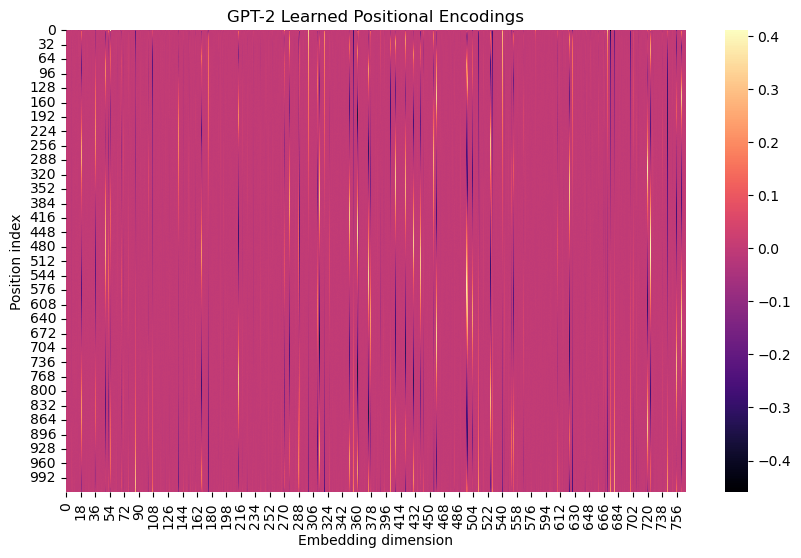

In [36]:
plt.figure(figsize=(10, 6))
#sns.heatmap(positional_encodings, cmap="magma")
sns.heatmap(normed_pe, cmap="magma")
plt.title("GPT-2 Learned Positional Encodings")
plt.xlabel("Embedding dimension")
plt.ylabel("Position index")
plt.show()

### Plot what the heatmap would look like in the case of sinusoidal positional encoding

**ABOUT THE CHOICE OF THE SCALING FACTOR:**
In sinusoidal encoding the value of L(scaling factor) is chosen arbitrarily: it controls how fast the frequencies change across dimensions in the positional encoding. This generates exponentially decreasing frequencies across the embedding dimensions, starting from high frequency in low dimensions (fast oscillation) and getting slower in higher dimensions (slow oscillation).

By **decreasing L**: 
- the frequencies change more quickly across dimensions
- you get higher-frequency patterns (more oscillations) overall
- encodings may distinguish positions more sharply over short distances
- but generalization over longer sequences might degrade (less smoothness)

By **increasing L**: 
- the frequencies vary more slowly.
- you get lower-frequency sinusoids.
- Position encodings change more smoothly — better for capturing long-range patterns but worse for fine-grained local distinctions.

**Summarizing**: 

Changing base is like tuning the "zoom" level of your positional lens:
- _Lower base_ → more detail (zoomed in),
- _Higher base_ → broader view (zoomed out).

In [37]:
# In our usual notation: 
#   max_len = N
#   d_model = D
#   You can check what happens varying L (here is 1000.0) --> just a rescaling
def sinusoidal_positional_encoding(max_len, d_model):
    pe = np.zeros((max_len, d_model)) # Initialize the PE matrix with all zeros
    position = np.arange(0, max_len)[:, np.newaxis] # Column vector of positions
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(1000.0) / d_model)) # define the frequencies
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

# Generate sinusoidal positional encodings
sinusoidal_encodings = sinusoidal_positional_encoding(1024, 768)

# # Normalize for better comparison with sinusoidal encoding
normed_se = sinusoidal_encodings / np.linalg.norm(sinusoidal_encodings, axis=1, keepdims=True)


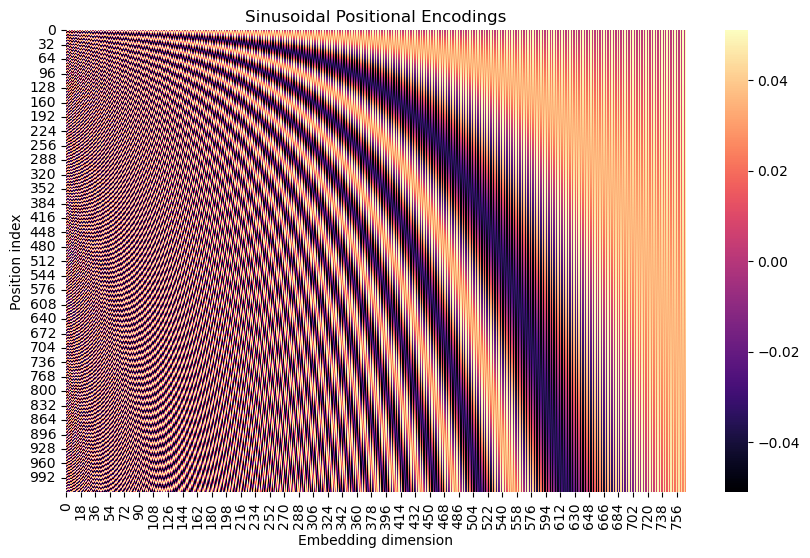

In [39]:
# Plot sinusoidal encodings
plt.figure(figsize=(10, 6))
# sns.heatmap(sinusoidal_encodings, cmap="magma")
sns.heatmap(normed_se, cmap="magma")
plt.title("Sinusoidal Positional Encodings")
plt.xlabel("Embedding dimension")
plt.ylabel("Position index")
plt.show()


### PCA 
**Each point in the 2D plot corresponds to one position (0 to 1023), represented in the reduced PCA space**.

- Both learned (GPT-2) and sinusoidal matrices are size 1024 × 768: each row is a position vector, each column is an embedding dimension.

- PCA helps reduce high-dimensional vectors to 2D or 3D, so you can visualize trajectories or structures in position space.

- It allows us to compare how the position vectors evolve across n and see whether the learned embeddings form curved, linear, or more complex manifolds.

**NOTICE**: PC1 and PC2 here and also in the above plot are not the same for both trajectories. Each one has its own principal components.

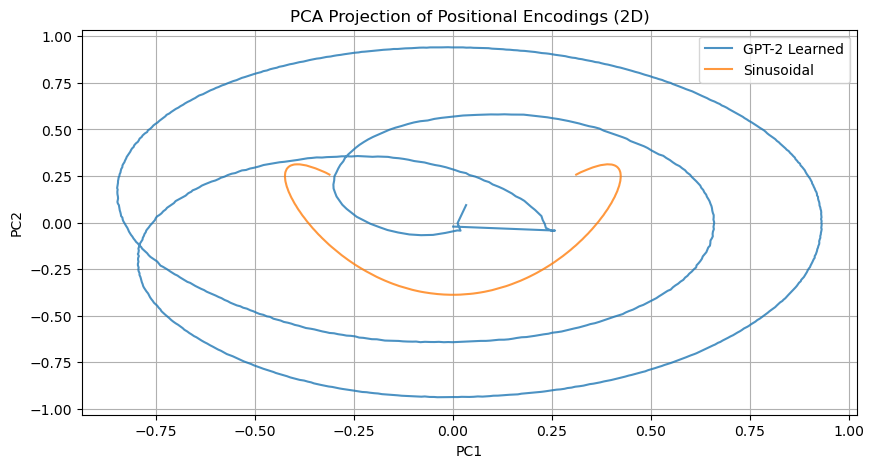

In [40]:
from sklearn.decomposition import PCA

# INDEPENDENT PCA FOR THE TWO ENCODINGS
# Allows to study the INTERNAL STRUCTURE of each encoding system

# Apply PCA to reduce dimensionality from 768 to 2
pca = PCA(n_components=2)
#gpt2_pca = pca.fit_transform(positional_encodings)
gpt2_pca = pca.fit_transform(normed_pe)
#sine_pca = pca.fit_transform(sinusoidal_encodings)
sine_pca = pca.fit_transform(normed_se)

# Plot both
plt.figure(figsize=(10, 5))
plt.plot(gpt2_pca[:, 0], gpt2_pca[:, 1], label="GPT-2 Learned", alpha=0.8)
plt.plot(sine_pca[:, 0], sine_pca[:, 1], label="Sinusoidal", alpha=0.8)
plt.title("PCA Projection of Positional Encodings (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()


**NOTICE:**

PCA to combined data would create a shared feature space where both encoding methods are projected using the same principal components. This would:

- Allow direct comparison of how different positions are encoded relative to each other across the two methods;

- Reveal whether the methods cluster separately or have regions of overlap; 

- Potentially highlight which encoding method captures more variance along which dimensions; 

- Show how the two methods differ in their actual embedding spaces rather than in their independently optimized projections. 

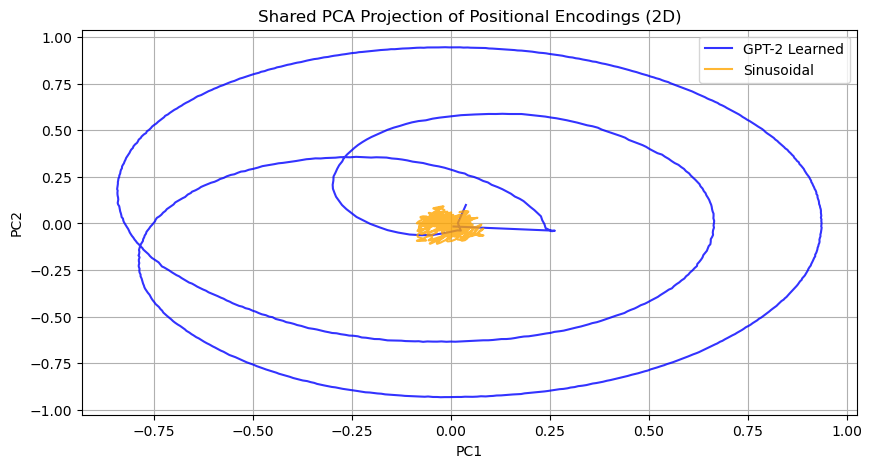

In [42]:
# PCA ON THE WHOLE DATA (BOTH ENCODINGS)
# Allows to consider a shared feature space where both encoding methods are projected 

# Concatenate both encodings along the position axis
# combined_encodings = np.vstack([positional_encodings, sinusoidal_encodings])
combined_encodings = np.vstack([normed_pe, normed_se])

# Fit PCA on the combined data
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined_encodings)

# Split the transformed encodings
#gpt2_pca = combined_pca[:positional_encodings.shape[0]]
gpt2_pca = combined_pca[:normed_pe.shape[0]]
#sine_pca = combined_pca[positional_encodings.shape[0]:]
sine_pca = combined_pca[normed_se.shape[0]:]

# Plot both in the shared PCA space
plt.figure(figsize=(10, 5))
plt.plot(gpt2_pca[:, 0], gpt2_pca[:, 1], label="GPT-2 Learned", alpha=0.8, color='blue')
plt.plot(sine_pca[:, 0], sine_pca[:, 1], label="Sinusoidal", alpha=0.8, color='orange')
plt.title("Shared PCA Projection of Positional Encodings (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

### Animated version

Animation saved to /Users/giorgiafasiolo/Documents/UniPd/2nd semester/LCPB/Transformers/separate_pca_positional_encoding.mp4


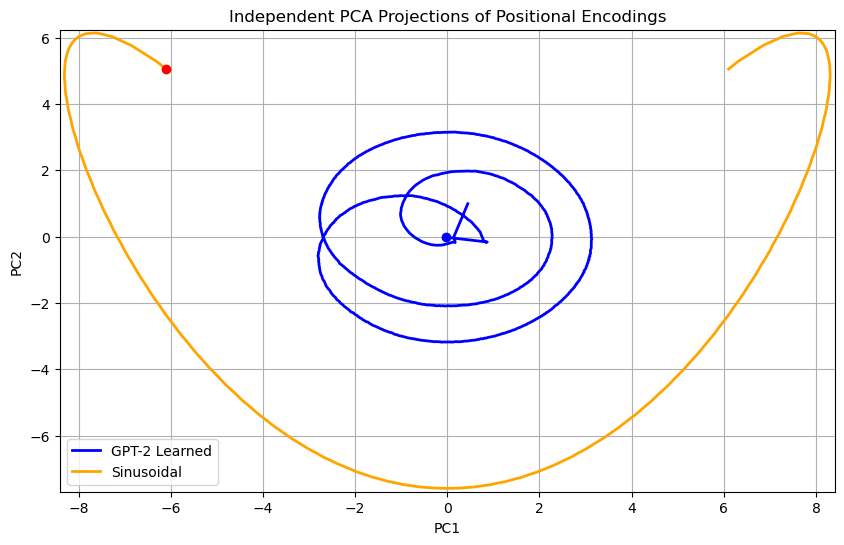

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Video
from sklearn.decomposition import PCA
import os

# Separate PCA projections
pca_gpt2 = PCA(n_components=2)
gpt2_pca = pca_gpt2.fit_transform(positional_encodings)

pca_sine = PCA(n_components=2)
sine_pca = pca_sine.fit_transform(sinusoidal_encodings)

# Set up plot
fig, ax = plt.subplots(figsize=(10, 6))
gpt2_line, = ax.plot([], [], lw=2, color='blue', label='GPT-2 Learned')
sine_line, = ax.plot([], [], lw=2, color='orange', label='Sinusoidal')
gpt2_point, = ax.plot([], [], 'bo')  # Blue dot
sine_point, = ax.plot([], [], 'ro')  # Red dot

# Combined axis limits for consistent visual space
combined = np.vstack([gpt2_pca, sine_pca])
ax.set_xlim(combined[:, 0].min() - 0.1, combined[:, 0].max() + 0.1)
ax.set_ylim(combined[:, 1].min() - 0.1, combined[:, 1].max() + 0.1)
ax.set_title("Independent PCA Projections of Positional Encodings")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
ax.grid(True)

# Init function
def init():
    gpt2_line.set_data([], [])
    sine_line.set_data([], [])
    gpt2_point.set_data([], [])
    sine_point.set_data([], [])
    return gpt2_line, sine_line, gpt2_point, sine_point

# Update function
def update(frame):
    gpt2_line.set_data(gpt2_pca[:frame+1, 0], gpt2_pca[:frame+1, 1])
    sine_line.set_data(sine_pca[:frame+1, 0], sine_pca[:frame+1, 1])
    gpt2_point.set_data([gpt2_pca[frame, 0]], [gpt2_pca[frame, 1]])
    sine_point.set_data([sine_pca[frame, 0]], [sine_pca[frame, 1]])
    return gpt2_line, sine_line, gpt2_point, sine_point

# Create animation
ani = animation.FuncAnimation(fig, update, frames=range(gpt2_pca.shape[0]),
                              init_func=init, blit=True, interval=10, repeat=False)

# Save animation
output_file = "separate_pca_positional_encoding.mp4"
# ani.save(output_file, fps=30, extra_args=['-vcodec', 'libx264'])

print(f"Animation saved to {os.path.abspath(output_file)}")

# Display in notebook
Video(output_file, embed=True)


Animation saved to /Users/giorgiafasiolo/Documents/UniPd/2nd semester/LCPB/Transformers/shared_pca_positional_encoding.mp4


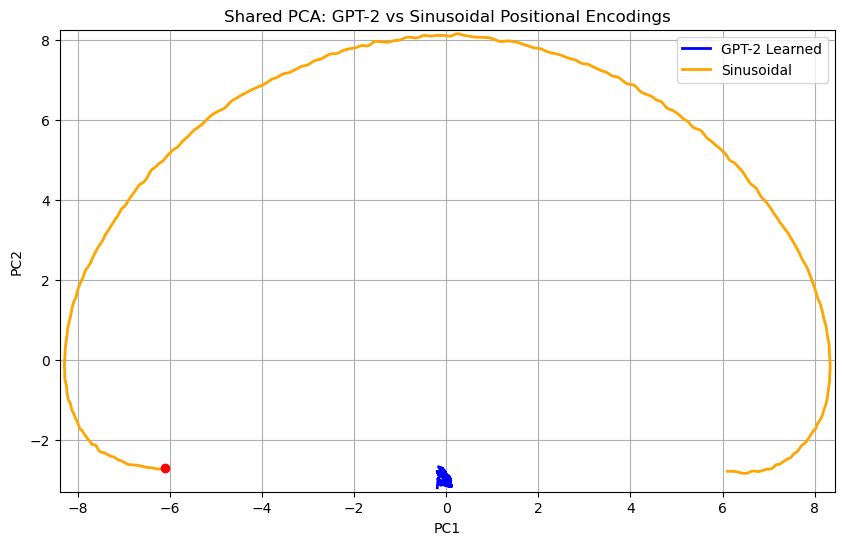

In [ ]:
# Set up plot
fig, ax = plt.subplots(figsize=(10, 6))
gpt2_line, = ax.plot([], [], lw=2, color='blue', label='GPT-2 Learned')
sine_line, = ax.plot([], [], lw=2, color='orange', label='Sinusoidal')
gpt2_point, = ax.plot([], [], 'bo')  # Blue dot
sine_point, = ax.plot([], [], 'ro')  # Red dot

# Shared axis limits
combined = np.vstack([gpt2_pca, sine_pca])
ax.set_xlim(combined[:, 0].min() - 0.1, combined[:, 0].max() + 0.1)
ax.set_ylim(combined[:, 1].min() - 0.1, combined[:, 1].max() + 0.1)
ax.set_title("Shared PCA: GPT-2 vs Sinusoidal Positional Encodings")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
ax.grid(True)

# Init function
def init():
    gpt2_line.set_data([], [])
    sine_line.set_data([], [])
    gpt2_point.set_data([], [])
    sine_point.set_data([], [])
    return gpt2_line, sine_line, gpt2_point, sine_point

# Update function
def update(frame):
    gpt2_line.set_data(gpt2_pca[:frame+1, 0], gpt2_pca[:frame+1, 1])
    sine_line.set_data(sine_pca[:frame+1, 0], sine_pca[:frame+1, 1])
    gpt2_point.set_data([gpt2_pca[frame, 0]], [gpt2_pca[frame, 1]])
    sine_point.set_data([sine_pca[frame, 0]], [sine_pca[frame, 1]])
    return gpt2_line, sine_line, gpt2_point, sine_point

# Create animation
ani = animation.FuncAnimation(fig, update, frames=gpt2_pca.shape[0],
                              init_func=init, blit=True, interval=10, repeat=False)

# Save animation
output_file = "shared_pca_positional_encoding.mp4"
# ani.save(output_file, fps=30, extra_args=['-vcodec', 'libx264'])

print(f"Animation saved to {os.path.abspath(output_file)}")

# Display animation in notebook
Video(output_file, embed=True)


##### **NORMALIZING BOTH BEFORE PCA**

Animation saved to /Users/giorgiafasiolo/Documents/UniPd/2nd semester/LCPB/Transformers/separate_pca_normalized_positional_encoding.mp4


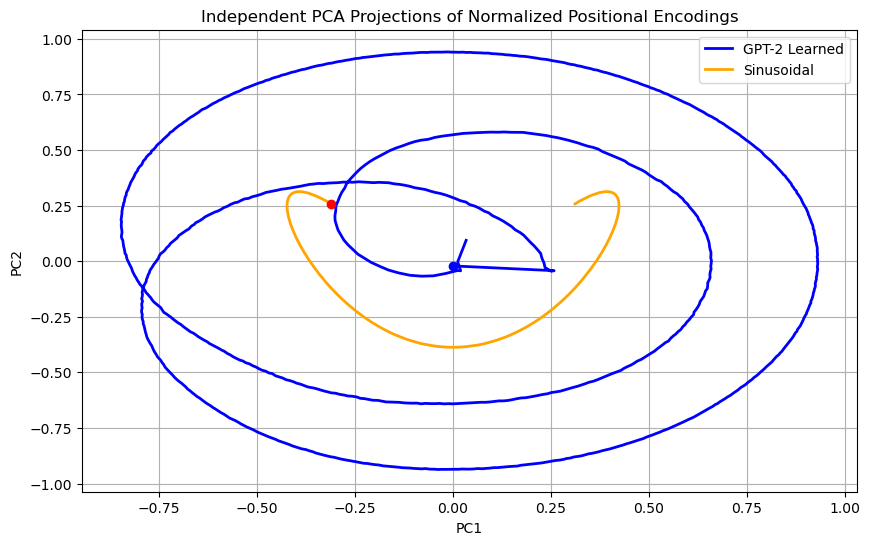

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Video
from sklearn.decomposition import PCA
import os

# Separate PCA projections on normalized encodings
pca_gpt2 = PCA(n_components=2)
gpt2_pca = pca_gpt2.fit_transform(normed_pe)

pca_sine = PCA(n_components=2)
sine_pca = pca_sine.fit_transform(normed_se)

# Set up plot
fig, ax = plt.subplots(figsize=(10, 6))
gpt2_line, = ax.plot([], [], lw=2, color='blue', label='GPT-2 Learned')
sine_line, = ax.plot([], [], lw=2, color='orange', label='Sinusoidal')
gpt2_point, = ax.plot([], [], 'bo')  # Blue dot
sine_point, = ax.plot([], [], 'ro')  # Red dot

# Combined axis limits for consistent visual space
combined = np.vstack([gpt2_pca, sine_pca])
ax.set_xlim(combined[:, 0].min() - 0.1, combined[:, 0].max() + 0.1)
ax.set_ylim(combined[:, 1].min() - 0.1, combined[:, 1].max() + 0.1)
ax.set_title("Independent PCA Projections of Normalized Positional Encodings")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
ax.grid(True)

# Init function
def init():
    gpt2_line.set_data([], [])
    sine_line.set_data([], [])
    gpt2_point.set_data([], [])
    sine_point.set_data([], [])
    return gpt2_line, sine_line, gpt2_point, sine_point

# Update function
def update(frame):
    gpt2_line.set_data(gpt2_pca[:frame+1, 0], gpt2_pca[:frame+1, 1])
    sine_line.set_data(sine_pca[:frame+1, 0], sine_pca[:frame+1, 1])
    gpt2_point.set_data([gpt2_pca[frame, 0]], [gpt2_pca[frame, 1]])
    sine_point.set_data([sine_pca[frame, 0]], [sine_pca[frame, 1]])
    return gpt2_line, sine_line, gpt2_point, sine_point

# Create animation
ani = animation.FuncAnimation(fig, update, frames=range(gpt2_pca.shape[0]),
                              init_func=init, blit=True, interval=10, repeat=False)

# Save animation
output_file = "separate_pca_normalized_positional_encoding.mp4"
# ani.save(output_file, fps=30, extra_args=['-vcodec', 'libx264'])

print(f"Animation saved to {os.path.abspath(output_file)}")

# Display in notebook
Video(output_file, embed=True)


Animation saved to /Users/giorgiafasiolo/Documents/UniPd/2nd semester/LCPB/Transformers/shared_pca_normalized_positional_encoding.mp4


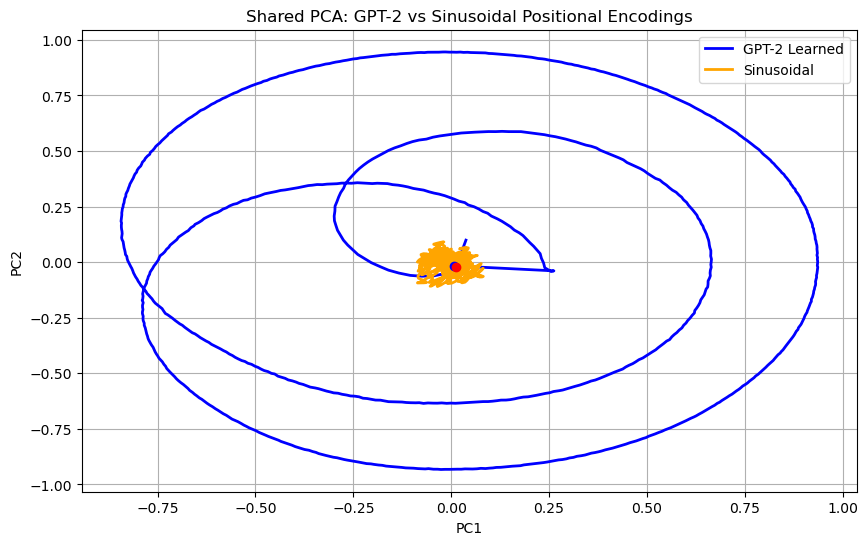

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Video
from sklearn.decomposition import PCA
import os

# Concatenate normalized encodings and apply shared PCA
combined_encodings = np.vstack([normed_pe, normed_se])
pca_shared = PCA(n_components=2)
combined_pca = pca_shared.fit_transform(combined_encodings)

# Split back into GPT-2 and Sinusoidal projections
split_index = normed_pe.shape[0]
gpt2_pca = combined_pca[:split_index]
sine_pca = combined_pca[split_index:]

# Set up plot
fig, ax = plt.subplots(figsize=(10, 6))
gpt2_line, = ax.plot([], [], lw=2, color='blue', label='GPT-2 Learned')
sine_line, = ax.plot([], [], lw=2, color='orange', label='Sinusoidal')
gpt2_point, = ax.plot([], [], 'bo')  # Blue dot
sine_point, = ax.plot([], [], 'ro')  # Red dot

# Shared axis limits
combined = np.vstack([gpt2_pca, sine_pca])
ax.set_xlim(combined[:, 0].min() - 0.1, combined[:, 0].max() + 0.1)
ax.set_ylim(combined[:, 1].min() - 0.1, combined[:, 1].max() + 0.1)
ax.set_title("Shared PCA: GPT-2 vs Sinusoidal Positional Encodings")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
ax.grid(True)

# Init function
def init():
    gpt2_line.set_data([], [])
    sine_line.set_data([], [])
    gpt2_point.set_data([], [])
    sine_point.set_data([], [])
    return gpt2_line, sine_line, gpt2_point, sine_point

# Update function
def update(frame):
    gpt2_line.set_data(gpt2_pca[:frame+1, 0], gpt2_pca[:frame+1, 1])
    sine_line.set_data(sine_pca[:frame+1, 0], sine_pca[:frame+1, 1])
    gpt2_point.set_data([gpt2_pca[frame, 0]], [gpt2_pca[frame, 1]])
    sine_point.set_data([sine_pca[frame, 0]], [sine_pca[frame, 1]])
    return gpt2_line, sine_line, gpt2_point, sine_point

# Create animation
ani = animation.FuncAnimation(fig, update, frames=gpt2_pca.shape[0],
                              init_func=init, blit=True, interval=10, repeat=False)

# Save animation
output_file = "shared_pca_normalized_positional_encoding.mp4"
# ani.save(output_file, fps=30, extra_args=['-vcodec', 'libx264'])

print(f"Animation saved to {os.path.abspath(output_file)}")

# Display animation in notebook
Video(output_file, embed=True)


**NOTICE:**
Normalization influences a lot the result!!! This means that scale matters: the original magnitued of these encoding methodsa re intentionally different. 

### Norm differences per row

Compute norms of differences per row (position vector-wise difference):

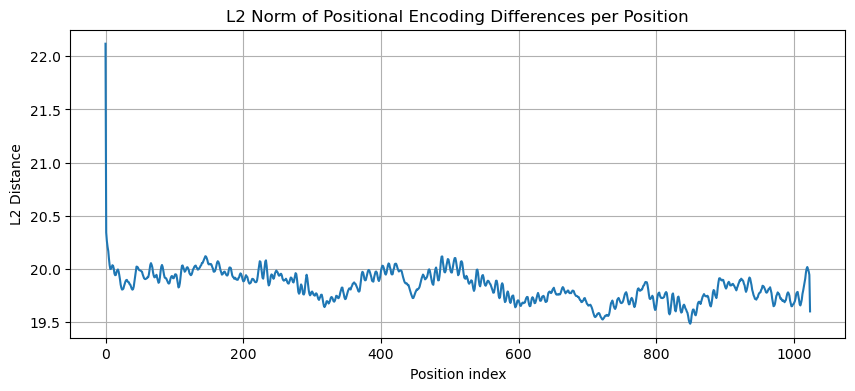

In [47]:
row_diffs = np.linalg.norm(positional_encodings - sinusoidal_encodings, axis=1)
#row_diffs = np.linalg.norm(normed_pe - normed_se, axis=1)

plt.figure(figsize=(10, 4))
plt.plot(row_diffs)
plt.title("L2 Norm of Positional Encoding Differences per Position")
plt.xlabel("Position index")
plt.ylabel("L2 Distance")
plt.grid(True)
plt.show()


### Evolution of positional vectors as n increases (from 1 to N) along different dimensions

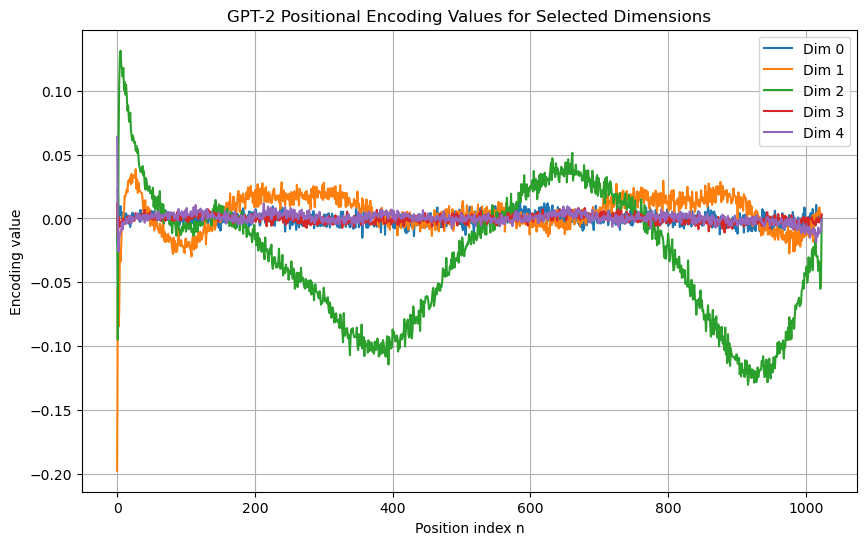

In [22]:
dims_to_plot = [0, 1, 2, 3, 4]

plt.figure(figsize=(10, 6))
for dim in dims_to_plot:
    plt.plot(positional_encodings[:, dim], label=f"Dim {dim}")
plt.title("GPT-2 Positional Encoding Values for Selected Dimensions")
plt.xlabel("Position index n")
plt.ylabel("Encoding value")
plt.legend()
plt.grid(True)
plt.show()


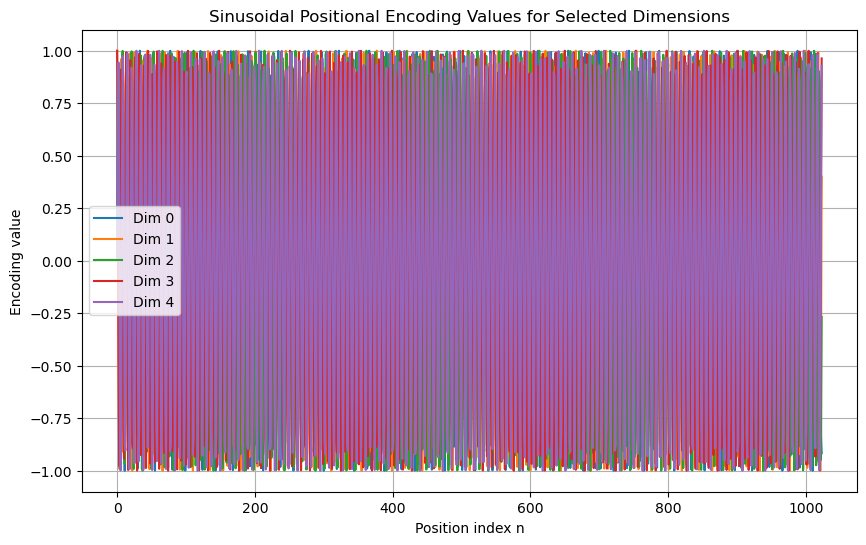

In [23]:
plt.figure(figsize=(10, 6))
for dim in dims_to_plot:
    plt.plot(sinusoidal_encodings[:, dim], label=f"Dim {dim}")
plt.title("Sinusoidal Positional Encoding Values for Selected Dimensions")
plt.xlabel("Position index n")
plt.ylabel("Encoding value")
plt.legend()
plt.grid(True)
plt.show()


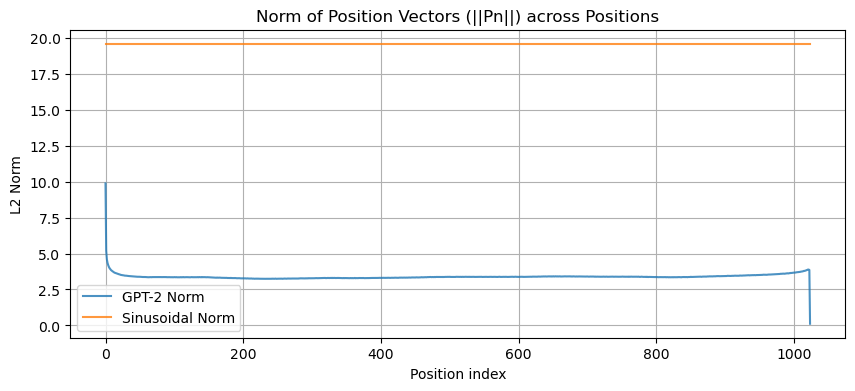

In [48]:
gpt2_norms = np.linalg.norm(positional_encodings, axis=1)
sine_norms = np.linalg.norm(sinusoidal_encodings, axis=1)

plt.figure(figsize=(10, 4))
plt.plot(gpt2_norms, label="GPT-2 Norm", alpha=0.8)
plt.plot(sine_norms, label="Sinusoidal Norm", alpha=0.8)
plt.title("Norm of Position Vectors (||Pn||) across Positions")
plt.xlabel("Position index")
plt.ylabel("L2 Norm")
plt.legend()
plt.grid(True)
plt.show()


### Cosine similarity evolution

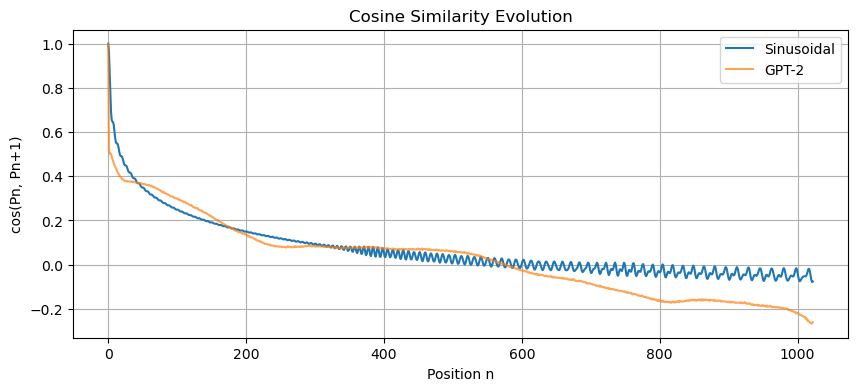

In [51]:
cos_sim_sine = [
    cosine_similarity([sinusoidal_encodings[i]], [sinusoidal_encodings[0]])[0, 0]
    for i in range(len(sinusoidal_encodings) - 1)
]

plt.figure(figsize=(10, 4))
plt.plot(cos_sim_sine, label="Sinusoidal")
plt.plot(cos_sim, label="GPT-2", alpha=0.7)
plt.title("Cosine Similarity Evolution")
plt.xlabel("Position n")
plt.ylabel("cos(Pn, Pn+1)")
plt.legend()
plt.grid(True)
plt.show()
